In [5]:
import os
import math
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
import numpy as np

In [6]:
# Hyper-params
SCALE = 2
LR_INPUT_SIZE = 128
HR_CROP_SIZE = LR_INPUT_SIZE * SCALE
PATCH_SIZE = 96
STRIDE = 64
PAD = 16
OVERLAP = PATCH_SIZE - STRIDE
BATCH_SIZE = 1
EPOCHS = 50
STEPS_PER_EPOCH = 200
LEARNING_RATE = 1e-4

AUTOTUNE = tf.data.AUTOTUNE
DEVICE = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

try:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print("Mixed precision enabled.")
    USE_MIXED_PRECISION = True
except Exception:
    USE_MIXED_PRECISION = False
    print("Mixed precision not enabled or not available.")

Mixed precision not enabled or not available.


In [7]:
# DIV2K Dataset Preparation
def prepare_div2k_dataset(split='train', hr_crop_size=HR_CROP_SIZE, lr_size=LR_INPUT_SIZE, batch_size=BATCH_SIZE):
    ds = tfds.load('div2k', split=split, shuffle_files=True, as_supervised=True)
    def extract_image(example):
        if isinstance(example, tuple) and len(example) == 2:\
            img = example[1]  # hr
        elif isinstance(example, dict):
            if 'hr' in example:
                img = example['hr']
            elif 'image' in example:
                img = example['image']
            else:
                img = list(example.values())[0]
        else:
            img = example
        img = tf.cast(img, tf.float32) / 255.0
        return img

    ds = ds.map(lambda a, b=None: extract_image(a), num_parallel_calls=AUTOTUNE)

    #Random cropping to get 256*256
    def random_crop_and_downscale(hr):
        hr = tf.image.random_crop(hr, size=[hr_crop_size, hr_crop_size, 3])
        # downscaling to LR size using bicubic
        lr = tf.image.resize(hr, [lr_size, lr_size], method='bicubic')
        return lr, hr

    ds = ds.map(lambda x: random_crop_and_downscale(x), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(512).batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = prepare_div2k_dataset('train', HR_CROP_SIZE, LR_INPUT_SIZE, BATCH_SIZE)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.C09C0U_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.C09C0U_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Generator: SRGAN

def residual_block(x_in, filters=64, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1,2])(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x_in, x])
    return x

class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, x):
        return tf.nn.depth_to_space(x, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config


def upsample_block(x, filters=256, scale=2):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = PixelShuffle(scale=scale)(x)
    x = layers.PReLU(shared_axes=[1,2])(x)
    return x


def build_generator(num_res_blocks=8, filters=64, scale=SCALE):
    inputs = layers.Input(shape=(None, None, 3))
    x = layers.Conv2D(filters, 9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1,2])(x)
    skip = x

    for _ in range(num_res_blocks):
        x = residual_block(x, filters)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, skip])

    n_ups = int(math.log(scale, 2))
    for _ in range(n_ups):
        x = upsample_block(x, filters*4, scale=2)

    out = layers.Conv2D(3, 9, padding='same', activation='tanh')(x)
    out = (out + 1.0) / 2.0
    model = models.Model(inputs, out, name='generator')
    return model

In [9]:
# Discriminator

def disc_block(x, filters, strides=1, batchnorm=True):
    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_discriminator(input_shape=(HR_CROP_SIZE, HR_CROP_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = disc_block(inputs, 64, batchnorm=False)
    x = disc_block(x, 64, strides=2)
    x = disc_block(x, 128)
    x = disc_block(x, 128, strides=2)
    x = disc_block(x, 256)
    x = disc_block(x, 256, strides=2)
    x = disc_block(x, 512)
    x = disc_block(x, 512, strides=2)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, out, name='discriminator')

In [10]:
# VGG feature extractor for content loss
def build_vgg_for_content():
    vgg = VGG19(weights='imagenet', include_top=False)
    content_layer = 'block5_conv4' if 'block5_conv4' in [l.name for l in vgg.layers] else vgg.layers[-1].name
    vgg_model = models.Model(vgg.input, vgg.get_layer(content_layer).output)
    vgg_model.trainable = False
    return vgg_model

In [ ]:
# Losses and optimizers
generator = build_generator()
discriminator = build_discriminator()
vgg_extractor = build_vgg_for_content()

g_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.9)
d_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.9)

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse = tf.keras.losses.MeanSquaredError()

real_label = tf.ones((BATCH_SIZE, 1))
fake_label = tf.zeros((BATCH_SIZE, 1))

if USE_MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    g_optimizer = mixed_precision.LossScaleOptimizer(g_optimizer, loss_scale='dynamic')
    d_optimizer = mixed_precision.LossScaleOptimizer(d_optimizer, loss_scale='dynamic')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training step
@tf.function
def train_step(lr_imgs, hr_imgs):

    # Train discriminator (conteny)
    with tf.GradientTape() as d_tape:
        fake_hr = generator(lr_imgs, training=True)
        real_pred = discriminator(hr_imgs, training=True)
        fake_pred = discriminator(fake_hr, training=True)
        d_loss_real = binary_cross_entropy(tf.ones_like(real_pred), real_pred)
        d_loss_fake = binary_cross_entropy(tf.zeros_like(fake_pred), fake_pred)
        d_loss = (d_loss_real + d_loss_fake) * 0.5

    d_vars = discriminator.trainable_variables
    d_grads = d_tape.gradient(d_loss, d_vars)
    d_optimizer.apply_gradients(zip(d_grads, d_vars))

    # Train generator (content + adversarial)
    with tf.GradientTape() as g_tape:
        fake_hr = generator(lr_imgs, training=False)
        fake_pred = discriminator(fake_hr, training=False)

        # content loss (VGG)
        def vgg_preprocess(x):
            x255 = x * 255.0
            return tf.keras.applications.vgg19.preprocess_input(x255)

        real_vgg = vgg_extractor(vgg_preprocess(hr_imgs))
        fake_vgg = vgg_extractor(vgg_preprocess(fake_hr))
        content_loss = mse(real_vgg, fake_vgg)

        # adversarial loss
        adv_loss = binary_cross_entropy(tf.ones_like(fake_pred), fake_pred)

        # pixel-wise MSE
        pixel_loss = mse(hr_imgs, fake_hr)

        # weighted total loss
        g_loss = content_loss * 1.0 + 1e-3 * adv_loss + 1e-2 * pixel_loss

        if USE_MIXED_PRECISION:
            scaled_loss = g_optimizer.get_scaled_loss(g_loss)
            grads = g_tape.gradient(scaled_loss, generator.trainable_variables)
            grads = g_optimizer.get_unscaled_gradients(grads)
        else:
            grads = g_tape.gradient(g_loss, generator.trainable_variables)

    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return {'d_loss': d_loss, 'g_loss': g_loss, 'content_loss': content_loss, 'adv_loss': adv_loss, 'pixel_loss': pixel_loss}

In [ ]:
#Training Loop
checkpoint_dir = '/content/checkpoints_srf'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                 g_optimizer=g_optimizer, d_optimizer=d_optimizer)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

print("Begin training on device:", DEVICE)
with tf.device(DEVICE):
    for epoch in range(EPOCHS):
        t0 = time.time()
        step = 0
        for lr_batch, hr_batch in train_ds.take(STEPS_PER_EPOCH):
            metrics = train_step(lr_batch, hr_batch)
            step += 1
            if step % 20 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} Step {step}/{STEPS_PER_EPOCH}"
                      f" D_loss={metrics['d_loss']:.4f} G_loss={metrics['g_loss']:.4f}")
        print(f"Epoch {epoch+1} completed in {time.time()-t0:.1f}s")
        manager.save()
print("Training loop finished. Checkpoints saved to", checkpoint_dir)

Begin training on device: /GPU:0
Epoch 1/50 Step 20/200 D_loss=0.0056 G_loss=6.5253
Epoch 1/50 Step 40/200 D_loss=0.0000 G_loss=43.9537
Epoch 1/50 Step 60/200 D_loss=0.4878 G_loss=35.5675
Epoch 1/50 Step 80/200 D_loss=0.0000 G_loss=63.7228
Epoch 1/50 Step 100/200 D_loss=0.0000 G_loss=17.8499
Epoch 1/50 Step 120/200 D_loss=0.0000 G_loss=8.5725
Epoch 1/50 Step 140/200 D_loss=0.0000 G_loss=6.2978
Epoch 1/50 Step 160/200 D_loss=0.0000 G_loss=33.8059
Epoch 1/50 Step 180/200 D_loss=0.0000 G_loss=18.8989
Epoch 1/50 Step 200/200 D_loss=0.0000 G_loss=58.7206
Epoch 1 completed in 116.7s
Epoch 2/50 Step 20/200 D_loss=0.0000 G_loss=7.7680
Epoch 2/50 Step 40/200 D_loss=0.0000 G_loss=26.6343
Epoch 2/50 Step 60/200 D_loss=0.0000 G_loss=5.0792
Epoch 2/50 Step 80/200 D_loss=5.9102 G_loss=29.5928
Epoch 2/50 Step 100/200 D_loss=0.0000 G_loss=28.9512
Epoch 2/50 Step 120/200 D_loss=0.0000 G_loss=16.5846
Epoch 2/50 Step 140/200 D_loss=0.0000 G_loss=34.8431
Epoch 2/50 Step 160/200 D_loss=0.0000 G_loss=25.366

In [ ]:

# Removing padding and stitching

def reflect_pad_image(img_tensor, pad):
    if img_tensor.ndim == 3:
        img_tensor = tf.expand_dims(img_tensor, 0)
    return tf.pad(img_tensor, [[0,0], [pad, pad], [pad, pad], [0,0]], mode='REFLECT')

def extract_tiles(padded_img, patch_size=PATCH_SIZE, stride=STRIDE):
    Hp = tf.shape(padded_img)[1]
    Wp = tf.shape(padded_img)[2]
    tiles = []
    starts = []
    y_positions = list(range(0, int(Hp.numpy()) - patch_size + 1, stride))
    x_positions = list(range(0, int(Wp.numpy()) - patch_size + 1, stride))
    for y in y_positions:
        for x in x_positions:
            tile = padded_img[:, y:y+patch_size, x:x+patch_size, :]
            tiles.append(tile)
            starts.append((y, x))
    return tiles, starts, Hp.numpy(), Wp.numpy()

def make_separable_weight(patch_out, overlap_out):
    if overlap_out <= 0:
        w = np.ones((patch_out,), dtype=np.float32)
    else:
        ramp = np.linspace(0.0, 1.0, overlap_out, endpoint=False, dtype=np.float32)
        w = np.ones((patch_out,), dtype=np.float32)
        w[:overlap_out] = ramp
        w[-overlap_out:] = ramp[::-1]
    w2d = np.outer(w, w).astype(np.float32)
    return w2d

def stitch_tiles(up_tiles, starts, Hp, Wp, scale=SCALE, patch_size=PATCH_SIZE, stride=STRIDE, overlap=OVERLAP, pad=PAD):
    patch_out = patch_size * scale
    overlap_out = overlap * scale
    out_h = Hp * scale
    out_w = Wp * scale
    C = up_tiles[0].shape[-1]

    acc = np.zeros((out_h, out_w, C), dtype=np.float32)
    weight_acc = np.zeros((out_h, out_w, 1), dtype=np.float32)

    w2d = make_separable_weight(patch_out, overlap_out)

    for tile, (y, x) in zip(up_tiles, starts):
        y0 = int(y) * scale
        x0 = int(x) * scale
        y1 = y0 + patch_out
        x1 = x0 + patch_out
        tile_np = tile[0].astype(np.float32)
        acc[y0:y1, x0:x1, :] += tile_np * w2d[..., None]
        weight_acc[y0:y1, x0:x1, 0] += w2d

    # normalize
    weight_acc = np.maximum(weight_acc, 1e-6)
    final_padded = acc / weight_acc

    # remove padding
    top = pad * scale
    left = pad * scale
    bottom = final_padded.shape[0] - pad * scale
    right = final_padded.shape[1] - pad * scale
    final = final_padded[top:bottom, left:right, :]
    final = np.clip(final, 0.0, 1.0)
    return final

# Inference wrapper
def upscale_image_with_tiling(lr_image, generator_model, scale=SCALE):

    img = lr_image.astype(np.float32)
    if img.ndim == 3:
        img_batch = np.expand_dims(img, 0)
    else:
        img_batch = img
    padded = tf.pad(img_batch, [[0,0], [PAD,PAD], [PAD,PAD], [0,0]], mode='REFLECT').numpy()

    tiles, starts, Hp, Wp = extract_tiles(tf.convert_to_tensor(padded), PATCH_SIZE, STRIDE)

    up_tiles = []
    for t in tiles:
        t = tf.cast(t, tf.float32)
        out = generator_model(t, training=False).numpy()
        up_tiles.append(out)
    # stitching
    final = stitch_tiles(up_tiles, starts, Hp, Wp, scale=scale, patch_size=PATCH_SIZE, stride=STRIDE, overlap=OVERLAP, pad=PAD)
    return final

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

checkpoint_dir = '/content/checkpoints_srf'
drive_checkpoint_dir = '/content/drive/MyDrive/my_checkpoints/SRGAN'

os.makedirs(drive_checkpoint_dir, exist_ok=True)

try:
    if os.path.exists(checkpoint_dir):
        shutil.copytree(checkpoint_dir, os.path.join(drive_checkpoint_dir, os.path.basename(checkpoint_dir)), dirs_exist_ok=True)
        print(f"Checkpoint files copied to {drive_checkpoint_dir}")
    else:
        print(f"Source checkpoint directory not found at {checkpoint_dir}")
except Exception as e:
    print(f"Error copying checkpoint files: {e}")

Checkpoint files copied to /content/drive/MyDrive/my_checkpoints/SRGAN


In [11]:
loaded_generator = build_generator()

drive_checkpoint_dir = '/content/drive/MyDrive/my_checkpoints/SRGAN/checkpoints_srf'

checkpoint = tf.train.Checkpoint(generator=loaded_generator)
latest_checkpoint = tf.train.latest_checkpoint(drive_checkpoint_dir)

if latest_checkpoint:
    status = checkpoint.restore(latest_checkpoint)

    status.expect_partial()
    print(f"Checkpoint loaded successfully from {latest_checkpoint}")
else:
    print(f"No checkpoint found in {drive_checkpoint_dir}")
    loaded_generator = None

Checkpoint loaded successfully from /content/drive/MyDrive/my_checkpoints/SRGAN/checkpoints_srf/ckpt-50


Upscaling and displaying 5 random images from the validation set:
Processing image 1/5...


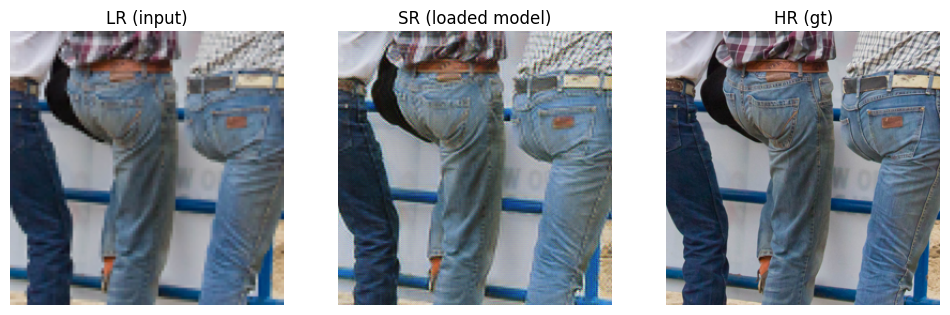

Processing image 2/5...


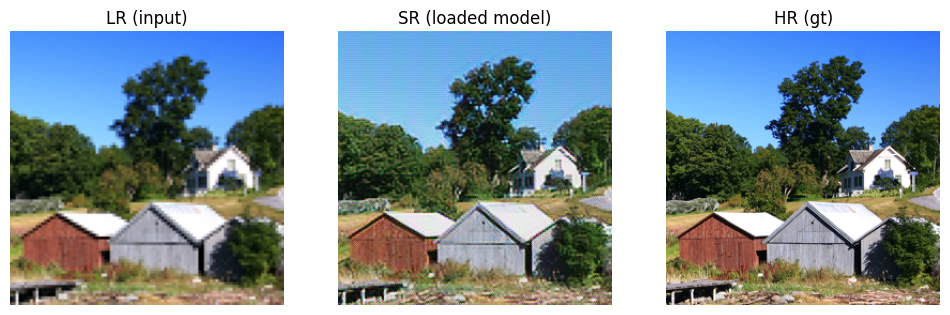

Processing image 3/5...


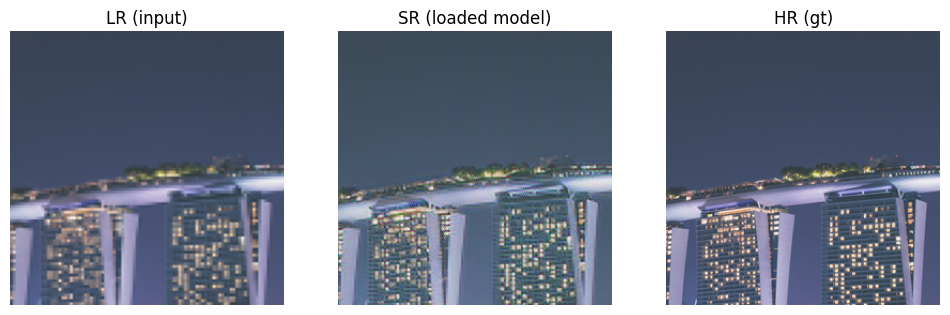

Processing image 4/5...


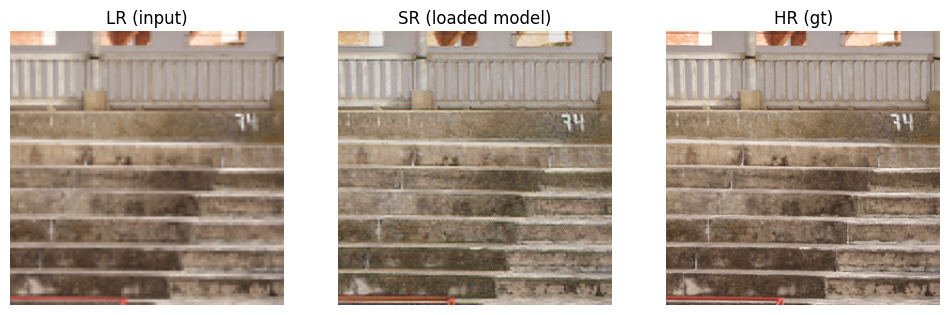

Processing image 5/5...


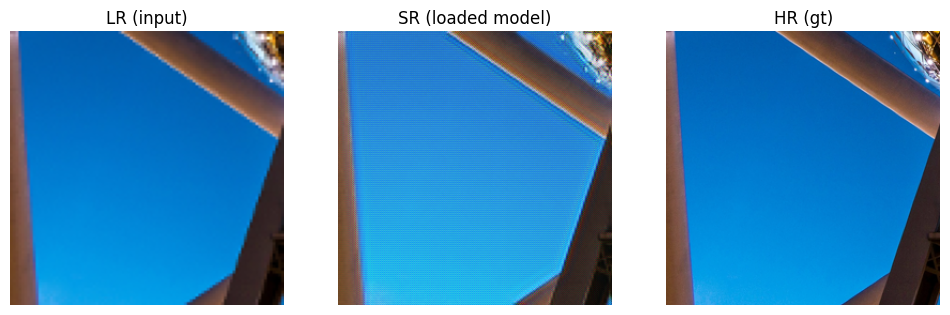

In [13]:
if loaded_generator:
    val_ds_inference = prepare_div2k_dataset('validation', HR_CROP_SIZE, LR_INPUT_SIZE, batch_size=1).take(5)

    import matplotlib.pyplot as plt
    import tensorflow as tf

    print("Upscaling and displaying 5 random images from the validation set:")
    for i, (lr_sample, hr_sample) in enumerate(val_ds_inference):
        lr_np = lr_sample[0].numpy()

        print(f"Processing image {i+1}/5...")
        sr_out_loaded = upscale_image_with_tiling(lr_np, loaded_generator)

        lr_display = tf.image.resize(lr_np, [128, 128], method='bicubic').numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.title("LR (input)"); plt.imshow(lr_display); plt.axis('off')
        plt.subplot(1, 3, 2); plt.title("SR (loaded model)"); plt.imshow(sr_out_loaded); plt.axis('off')
        plt.subplot(1, 3, 3); plt.title("HR (gt)"); plt.imshow(hr_sample[0].numpy()); plt.axis('off')
        plt.show()
else:
    print("Generator model was not loaded successfully. Please check the checkpoint path and try again.")